In [13]:
import pandas as pd
df = pd.read_csv('../data/filtered_attrs.csv')
label = 'label'
for row, l in enumerate(df['label']):
    if l > 4:
        df['label'][row] = 1
    else:
        df['label'][row] = 0
df = df.merge(right=pd.read_csv('../data/bias_labels.csv'), on='url', how='inner')
df.drop(columns=['url','source'], inplace=True)
df.groupby(label).describe().loc[:,(slice(None),['count'])]['backlinks']

/tmp/ipykernel_3239/289999582.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][row] = 0
/tmp/ipykernel_3239/289999582.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][row] = 1


,count
label,
0,601.0
1,2028.0


#### 2.3: Frequency x dependent variable

In [9]:
df.groupby(['bias', label]).describe().loc[:,(slice(None),['count'])]['backlinks']

count
bias label       
-2   0      116.0
     1      189.0
-1   0       60.0
     1      648.0
 0   0       17.0
     1      794.0
 1   0       60.0
     1      347.0
 2   0      348.0
     1       50.0

#### 2.4: Histograms

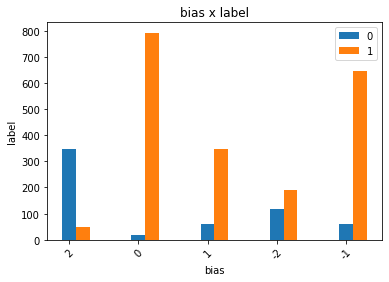

In [10]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

protected_attr = 'bias'

protected_freq = Counter(df[protected_attr])
counters = {}
for ind in protected_freq.keys():
    counters[ind] = Counter(df.loc[df[protected_attr] == ind][label])

ind = np.arange(len(counters.keys()))


dependent_vals = counters[list(protected_freq.keys())[0]].keys()
for width, val in enumerate(dependent_vals):
    vals = [counters[x][val] for x in counters.keys()]
    plt.bar(ind + width * 0.2, vals, 0.2, label=val)

plt.xlabel(protected_attr)
plt.ylabel(label)
plt.title(protected_attr + ' x ' + label)

# ticks = ind if i_key == 'age' else counters.keys()
plt.xticks(ind, counters.keys(), rotation=45)
plt.legend(dependent_vals)

plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
encoders = {}
df_encoded = df.copy()
for col in df.columns:
    if df[col].dtype == 'O':
        le = LabelEncoder()
        transformed_col = le.fit_transform(df[col])
        encoders[col] = le
        df_encoded[col] = transformed_col


In [15]:
from aif360.sklearn import metrics
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric

chosen_attribute = 'bias'

binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df,
    label_names=[label],
    protected_attribute_names=[chosen_attribute])


privileged_groups = [{'bias':-2}]
unprivileged_groups = [{'bias': 2}]

metric_orig = BinaryLabelDatasetMetric(binaryLabelDataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print(f"Disparate impact for the original dataset = {metric_orig.disparate_impact():.4f}")
print(f"Statistical parity difference for the original dataset = {metric_orig.statistical_parity_difference():.4f}")

Disparate impact for the original dataset = 0.2027
Statistical parity difference for the original dataset = -0.4940


### Compare classifier trained on original & preprocessed datasets

In [16]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover

binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df,
    label_names=[label],
    protected_attribute_names=[chosen_attribute])

# di = DisparateImpactRemover(0.75, 'bias')
di = Reweighing(unprivileged_groups, privileged_groups)#, attribute)
transformed_dataset = di.fit_transform(binaryLabelDataset)
orig_train, orig_test = binaryLabelDataset.split([0.7], shuffle=True)
trans_train, trans_test = transformed_dataset.split([0.7], shuffle=True)

original_dataset_metric = BinaryLabelDatasetMetric(binaryLabelDataset, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)

transformed_dataset_metric = BinaryLabelDatasetMetric(transformed_dataset, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)


In [17]:
orig_X_train = orig_train.features
orig_y_train = orig_train.labels.ravel()
orig_X_test = orig_test.features
orig_y_test = orig_test.labels.ravel()

trans_X_train = trans_train.features
trans_y_train = trans_train.labels.ravel()
trans_X_test = trans_test.features
trans_y_test = trans_test.labels.ravel()

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix

clf = RandomForestRegressor(n_estimators=50, random_state=0)
orig_clf = clf.fit(orig_X_train, orig_y_train)

scores = orig_clf.predict(orig_X_test)
predictions = scores > 0.5
errors = np.abs(orig_y_test - predictions)
acc_original = 1-np.mean(errors)
confusion_matrix(orig_y_test, predictions).ravel() # tn, fp, fn, tp 

array([125,  62,  27, 575])

In [19]:
trans_clf = clf.fit(trans_X_train, trans_y_train)

trans_scores = trans_clf.predict(trans_X_test)
trans_predictions = trans_scores > 0.5
trans_errors = np.abs(trans_y_test - trans_predictions)
acc_transformed = 1-np.mean(trans_errors)
confusion_matrix(orig_y_test, trans_predictions).ravel() # tn, fp, fn, tp 

array([ 32, 155, 122, 480])

In [20]:
from sklearn.metrics import roc_auc_score, accuracy_score
print(roc_auc_score(orig_y_test, predictions))
print(roc_auc_score(orig_y_test, trans_predictions))
print(accuracy_score(orig_y_test, predictions))
print(accuracy_score(orig_y_test, trans_predictions))

0.8117993497610461
0.4842325936717181
0.8871989860583016
0.6489226869455006


In [22]:
orig_test.scores = scores
trans_test.scores = trans_scores

test_metric_orig = BinaryLabelDatasetMetric(orig_test, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)

test_metric_transformed = BinaryLabelDatasetMetric(trans_test, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)

print("{:<30} {:<15} {:<15} {:<15} {:<15}".format('Experiment', 'DI', 'DI change', 'SPD', 'SPD change'))
print('-'*80)
print("{:<30} {:<15} {:<15} {:<15} {:<15}".format('Original data', f"{original_dataset_metric.disparate_impact():.4f}", 'Baseline', f"{original_dataset_metric.statistical_parity_difference():.4f}", 'Baseline'))
print("{:<30} {:<15} {:<15} {:<15} {:<15}".format('Transformed data', f"{transformed_dataset_metric.disparate_impact():.4f}", 'Positive',  f"{transformed_dataset_metric.disparate_impact():.4f}", 'Positive'))
print("{:<30} {:<15} {:<15} {:<15} {:<15}".format('Classifier on original data', f"{test_metric_orig.disparate_impact():.4f}", 'No change', f"{test_metric_orig.statistical_parity_difference():.4f}", 'No change'))
print("{:<30} {:<15} {:<15} {:<15} {:<15}".format('Classifier on transformed data', f"{test_metric_transformed.disparate_impact():.4f}", 'Positive', f"{test_metric_transformed.statistical_parity_difference():.4f}", 'Positive'))


Experiment                     DI              DI change       SPD             SPD change     
--------------------------------------------------------------------------------
Original data                  0.2027          Baseline        -0.4940         Baseline       
Transformed data               1.0000          Positive        1.0000          Positive       
Classifier on original data    0.1952          No change       -0.4812         No change      
Classifier on transformed data 0.8901          Positive        -0.0843         Positive       
